# Evaluation on Pauli string sum

## Overview

We need to evaluate the sum of many Pauli string terms on the circuit in variaous quantum algorithoms, the ground state preparation of a Hamiltonian $H$ in VQE is an typical example.
We need to calculate the expectation value of Hamiltonian $H$, i.e., $\langle 0^N \vert U^{\dagger}(\theta) H U(\theta) \vert 0^N \rangle$ and update the parameters $\theta$ in $U(\theta)$ based on gradient descent in VQE workflow. In this tutorial, we will demonstrate five arpproaches supported in ``TensorCircuit`` to calculate $\langle H \rangle$: 

1. $\langle H \rangle = \sum_{i} \langle h_{i} \rangle$, where $h_{i}$ are the Pauli-string operators;

2. Similar to 1, but we evaluate the sum of Pauli string via ``vmap``;

3. $\langle H \rangle$ where $H$ is a sparse matrix;

4. $\langle H \rangle$ where $H$ is a dense matrix;

5. expectation value of the Matrix Product Operator (MPO) for $H$.

We consider transverse field ising model (TFIM) as the example, which reads
$$
H = \sum_{i} \sigma_{i}^{x} \sigma_{i+1}^{x} - \sum_{i} \sigma_{i}^{z},
$$
where $\sigma_{i}^{x,z}$ are Pauli matrices of the $i$-th qubit.

## Setup

In [1]:
import time
from functools import partial
import numpy as np
import tensorflow as tf
import tensornetwork as tn
import optax
import tensorcircuit as tc

K = tc.set_backend("tensorflow")

xx = tc.gates._xx_matrix  # xx gate matrix to be utilized

In [2]:
n = 10  # The number of qubits
nlayers = 4  # The number of circuit layers

## Parameterized Quantum Circuits

In [3]:
# Define the ansatz circuit to evaluate the Hamiltonian expectation
def tfim_circuit(param):
    c = tc.Circuit(n)
    for j in range(nlayers):
        for i in range(n - 1):
            c.exp1(i, i + 1, unitary=xx, theta=param[2 * j, i])
        for i in range(n):
            c.rz(i, theta=param[2 * j + 1, i])
    return c

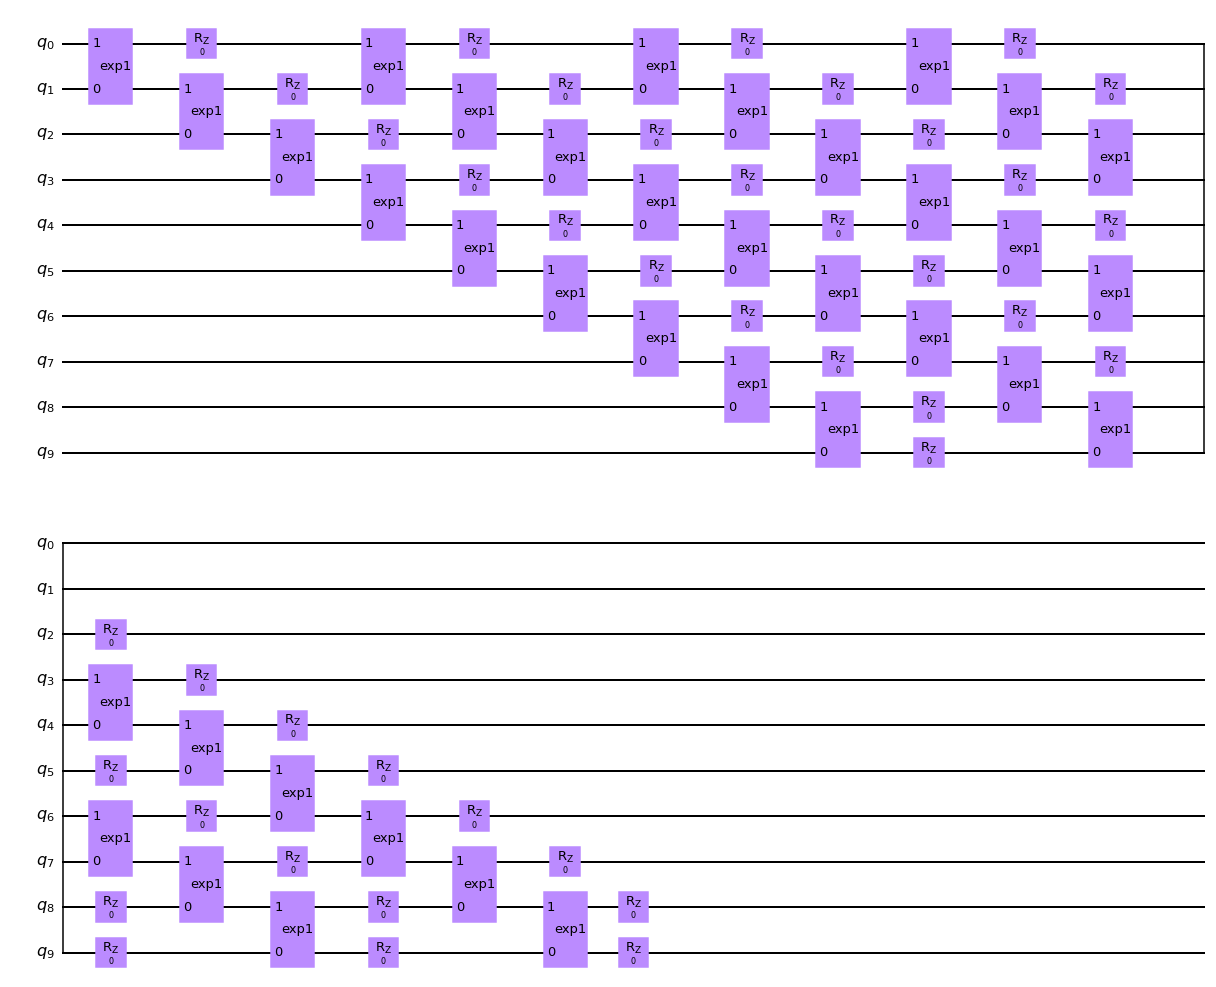

In [4]:
# the circuit ansatz we utilized is shown as below, the two-qubit gate is in ladder layout
tfim_circuit(K.zeros([2 * nlayers, n])).draw(output="mpl")

## Main Optimization Loop

VQE train loop (value and grad function agnostic) is defined below.

In [5]:
# We define the universal train_step function for different approaches evaluating the Pauli string sum
def train_step(vf, maxiter=400):
    param = K.implicit_randn(shape=[2 * nlayers, n], stddev=0.01)
    if K.name == "tensorflow":
        opt = K.optimizer(tf.keras.optimizers.Adam(1e-2))
    else:  # jax
        opt = K.optimizer(optax.adam(1e-2))
    vgf = tc.backend.jit(tc.backend.value_and_grad(vf))
    time0 = time.time()
    _ = vgf(param)
    time1 = time.time()
    print("staging time: ", time1 - time0)
    times = []
    for i in range(maxiter):
        time0 = time.time()
        e, grad = vgf(param)  # energy and gradients
        time1 = time.time()
        times.append(time1 - time0)
        param = opt.update(grad, param)
        if i % 200 == 0:
            print(e)
    print("running time: ", np.mean(times))
    return e

##  1. Pauli-string Operators Sum

In [6]:
# Sum the pauli string expectation in a plain way
def tfim_energy(c, j=1.0, h=-1.0):
    e = 0.0
    n = c._nqubits
    for i in range(n):
        e += h * c.expectation_ps(z=[i])  # <Z_i>
    for i in range(n - 1):  # OBC
        e += j * c.expectation_ps(x=[i, i + 1])  # <X_iX_{i+1}>
    return K.real(e)

In [7]:
def vqe_tfim_v1(param):
    c = tfim_circuit(param)
    e = tfim_energy(c)
    return e

In [8]:
train_step(vqe_tfim_v1)

staging time:  29.903974294662476
tf.Tensor(-9.9926815, shape=(), dtype=float32)
tf.Tensor(-11.69182, shape=(), dtype=float32)
running time:  0.004392582178115845


<tf.Tensor: shape=(), dtype=float32, numpy=-11.658401>

## 2. Vmap the Paui-string Operators Sum

A string of Pauli operators acting on $n$ qubits can be represented as a length $n$ vector $v\in\{0,1,2,3\}^n$, where the value of $v_i = j$ corresponds to $\sigma_i^j$, i.e. Pauli operator $\sigma^j$ acting on qubit $i$ (with $\sigma^0 = I, \sigma^1 = X, \sigma^2 = Y, \sigma^3 = Z$). For example, in this notation, if $n=3$ the term $X_1 X_2$ corresponds to $v = [0,1,1]$. We refer to such a vector representation of a Pauli string as a ``structure``, and a list of structures, one for each Pauli string term in the Hamiltonian, is used as the input to compute sums of expectation values in a number of ways.

If each structure has an associated weight, e.g. the term $X_i X_{i+1}$ has weight $J_i$ in TFIM Hamiltonian, then we  define a corresponding tensor of weights.

In [9]:
def measurement(s, structure):
    c = tc.Circuit(n, inputs=s)
    return tc.templates.measurements.parameterized_measurements(
        c, structure, onehot=True
    )


measurement = K.jit(K.vmap(measurement, vectorized_argnums=1))

structures = []
for i in range(n - 1):
    s = [0 for _ in range(n)]
    s[i] = 1
    s[i + 1] = 1
    structures.append(s)
for i in range(n):
    s = [0 for _ in range(n)]
    s[i] = 3
    structures.append(s)

structures = tc.array_to_tensor(structures)
weights = tc.array_to_tensor(
    np.array([1.0 for _ in range(n - 1)] + [-1.0 for _ in range(n)])
)

print(K.numpy(structures))
print(K.numpy(weights))


def vqe_tfim_v2(param):
    c = tfim_circuit(param)
    s = c.state()
    ms = measurement(s, structures)
    return K.sum(ms * K.real(weights))

[[1.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 1.+0.j]
 [3.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 3.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 3.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 3.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 3.+0.j 0.+0.j 0.+0.j 

In [10]:
train_step(vqe_tfim_v2)

staging time:  18.228847980499268
tf.Tensor(-9.991278, shape=(), dtype=float32)
tf.Tensor(-11.868717, shape=(), dtype=float32)
running time:  0.00716902494430542


<tf.Tensor: shape=(), dtype=float32, numpy=-11.842572>

## 3. Sparse Matrix

Significant computational advantage in terms of space and time can be obtained if the Hamiltonian is sparse, in which case a sparse representation of the operator is preferable. This can be provided in a backend agnostic way by converting from a list of Pauli structures in a two-stage process. First we convert to a sparse numpy matrix in COO (COOrdinate) format and then we convert is to coo sparse tensor on given ML backend.

In [11]:
def vqe_tfim_template(param, op):
    c = tfim_circuit(param)
    e = tc.templates.measurements.operator_expectation(
        c, op
    )  # in operator_expectation, the "hamiltonian" can be sparse matrix, dense matrix or mpo
    return e

In [12]:
# We first generate the Hamiltonian matrix as follows

hamiltonian_sparse_numpy = tc.quantum.PauliStringSum2COO_numpy(structures, weights)
hamiltonian_sparse_numpy

<1024x1024 sparse matrix of type '<class 'numpy.complex64'>'
	with 9988 stored elements in COOrdinate format>

In [13]:
hamiltonian_sparse = K.coo_sparse_matrix(
    np.transpose(
        np.stack([hamiltonian_sparse_numpy.row, hamiltonian_sparse_numpy.col])
    ),
    hamiltonian_sparse_numpy.data,
    shape=(2**n, 2**n),
)

In [14]:
vqe_tfim_v3 = partial(vqe_tfim_template, op=hamiltonian_sparse)

In [15]:
train_step(vqe_tfim_v3)

staging time:  13.532029867172241
tf.Tensor(-9.976083, shape=(), dtype=float32)
tf.Tensor(-11.907323, shape=(), dtype=float32)
running time:  0.002562386989593506


<tf.Tensor: shape=(), dtype=float32, numpy=-11.875302>

## 4. Dense Matrix

In [16]:
hamiltonian_dense = K.to_dense(hamiltonian_sparse)

In [17]:
vqe_tfim_v4 = partial(vqe_tfim_template, op=hamiltonian_dense)

In [18]:
train_step(vqe_tfim_v4)

staging time:  15.174713850021362
tf.Tensor(-9.981074, shape=(), dtype=float32)
tf.Tensor(-11.836525, shape=(), dtype=float32)
running time:  0.0039513856172561646


<tf.Tensor: shape=(), dtype=float32, numpy=-11.799629>

## 5. MPO

The TFIM Hamiltonian, as a short-ranged spin Hamiltonian, admits an efficient Matrix Product Operator representation. Again this is a two stage process using TensorCircuit. We first convert the Hamiltonian into an MPO representation via the TensorNetwork or Quimb package.

In [19]:
# generate the corresponding MPO by converting the MPO in tensornetwork package

Jx = np.array([1.0 for _ in range(n - 1)])  # strength of xx interaction (OBC)
Bz = np.array([1.0 for _ in range(n)])  # strength of transverse field
# Note the convention for the sign of Bz
hamiltonian_mpo = tn.matrixproductstates.mpo.FiniteTFI(
    Jx, Bz, dtype=np.complex64
)  # matrix product operator in TensorNetwork
hamiltonian_mpo = tc.quantum.tn2qop(hamiltonian_mpo)  # QuOperator in TensorCircuit

In [20]:
vqe_tfim_v5 = partial(vqe_tfim_template, op=hamiltonian_mpo)

In [21]:
train_step(vqe_tfim_v5)

staging time:  26.719671964645386
tf.Tensor(-9.985788, shape=(), dtype=float32)
tf.Tensor(-11.857734, shape=(), dtype=float32)
running time:  0.00492021381855011


<tf.Tensor: shape=(), dtype=float32, numpy=-11.828297>